# A Pedometer in the Real World
- 原文：http://aosabook.org/en/500L/a-pedometer-in-the-real-world.html
- 代码和数据：https://github.com/aosabook/500lines/tree/master/pedometer

## 1 A Perfect World
许多软件工程师在培训时都知道在一个非常完美的世界中解决问题会很愉快，而且我们经常解决在理想领域中定义明确的问题。

然而我们所处的现实世界有相当的复杂性和挑战——它实在是太乱了，但这也更加令人兴奋。只有能够解决现实生活中的问题，才可以构建出真正对人们有帮助的软件。

在本章中，我们研究如何构建一个计步器。这是一个表面上看起来很简单，但在现实世界中却很复杂的问题。我们先从理论开始讨论计数解决方案，然后用代码实现解决方案，最后添加一个Web层为用户提供一个友好的界面。

## 2 Pedometer Theory
移动设备的兴起带来了一种趋势，即收集越来越多的日常生活数据。其中一种数据类型是人们在一段时间内走的步数，这些数据可以用于健康跟踪，体育项目训练等。计步器通常使用加速度计（accelerometer）的数据作为输入计算出步数。

### 2.1 What's an Accelerometer?
加速度计是一种可测量x，y和z方向上加速度的硬件。现在人们都随身携带加速度计，因为几乎所有智能手机都内置了加速度计（这种情况下x，y和z方向相对于手机）。

加速度计返回一个包含3个维度（方向）上的信号，这个信号是随时间记录的一组数据点，并且每个分量都是一个时间序列，表示在x，y或z方向上的加速度。时间序列中的每个点都是该时间点和该方向上的加速度。加速度以$g$为单位测量，$1g$等于$9.8m/s^2$，这是地球重力引起的平均加速度。

下图给出了加速度计三个方向上的时序信号示例：

![](http://static.zybuluo.com/AustinMxnet/h058ltkz45earzs10xpqz71o/image.png)

加速度计的采样率决定了每秒的测量次数。例如，采样率为100的加速度计每秒钟返回x，y和z方向的时间序列的100个数据点。

### 2.2 Let's Talk About a Walk
一个人走路时，每一步都伴随着上下轻微振动（与地球重力方向相同），例如他的头部，躯干和臀部以平滑的振动动作同步。虽然这个幅度不大人（通常只有一到两厘米），但是它是人的步行加速度信号中最清晰，最恒定且最易识别的特征之一。

我们通过分析加速度计信号中重力方向上的弹跳数来计算步数。由于手机可以沿任何方向旋转，我们可以利用重力来得到向下的方向。下图展示了一个人的衬衫口袋中装有加速度计的智能手机走路情况：

![](http://static.zybuluo.com/AustinMxnet/3buq08iij6zkd2qewhge6hdt/image.png)

为了简单起见，我们假设这个人：
- 在z方向上行走
- 每一步沿y方向跳动
- 手机在整个步行过程中保持相同的方向

在这个理想世界中，y方向上的加速度形成一个理想的正弦波，每个波峰正好对应一步。于是步数计数变成了对这些理想波峰进行个数统计。这种快乐只存在完美世界，下面让这个世界多一点现实。

### 2.3 Even Perfect Worlds Have Fundamental Forces of Nature
地球重力产生了重力加速度，它比较特殊，因为它一直存在（即使静止情况下），这里设为$9.8m/s^2$。

假设智能手机屏幕朝上躺在桌子上，此时加速度计的坐标系中负z方向是地球重力所作用的方向。即使在静止不动的情况下，这时加速度计也会在负z方向上记录$ 9.8m/s^2$的加速度。下图展示了手机此时静止状态下的加速度计数据：

![](http://static.zybuluo.com/AustinMxnet/o2328rsh3asx0f9cjdqervtk/image.png)

加速度计记录了三个方向上的加速度，静止状态下$x(t)$和$y(t)$保持$0g$，但是$z(t)$等于$-1g$。

当有运动产生时，加速度计的值就是设备（用户）运动加速度+重力加速度：

![](http://static.zybuluo.com/AustinMxnet/9ckvj92ovhpe89ea7icjh3bd/image.png)

如上图所示，当手机静止不动，并且其加速度计坐标系中负z方向是地球重力所作用的方向时，去除重力加速度后，用户正常走路情况下的三个方向的加速度都是围绕着0上下波动。尽管曲线不是那么平滑，但是我们还是可以根据$y(t)$上的波峰来计算步数。我们再往现实世界靠近一些。

### 2.4 People Are Complicated Creatures
现实世界中，手机会出现在人们的口袋、包包甚至直接被人拿在手里，更差的情况是手机的方向也会随着人动而变化：

![](http://static.zybuluo.com/AustinMxnet/khn4lp4cw271fqvc00mq3nzx/image.png)

这种情况下，**速度计的三个方向都可能含有重力加速度，并且时刻变化**。为了确定用户在重力方向上的加速度变化，我们需要在各个方向上分解出含有的重力加速度：

![](http://static.zybuluo.com/AustinMxnet/0zzeliiax1g4f9hfbf9gg2g9/image.png)

整个计算分为两步：
1. 将加速度分为用户加速度和重力加速度
2. 在用户加速度中提取出重力方向上的加速度

#### 2.4.1 Splitting Total Acceleration Into User Acceleration and Gravitational Acceleration
我们使用滤波器将总加速时间序列分为用户加速时间序列和重力加速时间序列。

##### Low-Pass and High-Pass Filters

滤波器是用于信号处理，从信号中去除不需要的分量。

低通滤波器允许低频信号通过，过滤高于设置阈值的信号；相反，高通滤波器允许高频信号通过，过滤低于设置阈值的信号。用音乐作为类比，低通滤波器可以消除高音，而高通滤波器可以消除低音。

加速度计中，用Hz为单位的频率表示加速度变化的速度。恒定加速度的频率为0Hz，而非恒定加速度的频率为非0。这意味着恒定的重力加速度是0Hz信号，而用户加速度则不是。对于每个分量，我们都可以将总加速度通过一个低通滤波器，得到重力加速度时间序列。然后从总加速度中减去重力加速度，得到用户加速度时间序列：

![](http://static.zybuluo.com/AustinMxnet/gufr7zp96j6ws85ogcl0zi3p/image.png)

滤波器有很多种，这里我们用IIR (Infinite Impulse Response)滤波器，因为它很轻量并且容易实现。IIR滤波器公式如下：

$$\text{output}_{i}=\alpha_{0}\left(\text {input}_{i} \beta_{0}+\text {input}_{i-1} \beta_{1}+\text {input}_{i-2} \beta_{2}-\text {output}_{i-1} \alpha_{1}-\text {output}_{i-2} \alpha_{2}\right)$$

数字滤波器是一个很有趣，有着大量实际应用的专题，虽然理论分析设计不在本篇文章范畴内，但是我们可以简单讨论一下。数字滤波器经过设计可以过滤任何频率或者某个范围内频率的信号。上面公式中的$\alpha$和$\beta$是系数（参数），要根据目标范围调整。

首先我们需要保留恒定的重力加速度，即过滤掉别的频率信号，所以要选择合适$\alpha$和$\beta$。尽管重力加速度的变化率为0Hz（恒为$1g$），但是由于现实世界中存在各种干扰（例如设备误差等），所以我们可以稍微放宽标准，过滤掉0.2Hz以上的频率。

从初始化值0开始，$x_g(t)$和$z_g(t)$在0附近徘徊，而$y_g(t)$很快地收敛到$1g$。现在我们只需要在三个方向上减去重力加速度就可以得到用户运动的加速度：

$$\begin{array}{l}
x_{u}(t)=x(t)-x_{g}(t) \\
y_{u}(t)=y(t)-y_{g}(t) \\
z_{u}(t)=z(t)-z_{g}(t)
\end{array}$$

将重力加速度分离出去后的用户运动变化如下图所示，可以看到$y_u(t)$也是在0附近徘徊：

![](http://static.zybuluo.com/AustinMxnet/gypzntb2k2x3zei40p6cacpr/image.png)

##### Implementing a Low-Pass Filter
我们需要分解：
- $x(t)$ => $x_g(t)$和$x_u(t)$
- $y(t)$ => $y_g(t)$和$y_u(t)$
- $z(t)$ => $z_g(t)$和$z_u(t)$

IIR滤波器公式如下，过滤出三个方向上的重力加速度：

$$\begin{aligned} x_{g}(t) &=\alpha_{0}\left(x(t) \beta_{0}+x(t-1) \beta_{1}+x(t-2) \beta_{2}-x_{g}(t-1) \alpha_{1}-x_{g}(t-2) \alpha_{2}\right) \\ y_{g}(t) &=\alpha_{0}\left(y(t) \beta_{0}+y(t-1) \beta_{1}+y(t-2) \beta_{2}-y_{g}(t-1) \alpha_{1}-y_{g}(t-2) \alpha_{2}\right) \\ z_{g}(t) &=\alpha_{0}\left(z(t) \beta_{0}+z(t-1) \beta_{1}+z(t-2) \beta_{2}-z_{g}(t-1) \alpha_{1}-z_{g}(t-2) \alpha_{2}\right) \end{aligned}$$

由于IIR滤波器需要用到之前两个时刻的数据，所以初始化时候将一开始的两个数据设为0，从第三个数据开始计算：

$x_g(0)=x_g(1)=y_g(0)=y_g(1)=z_g(0)=z_g(1)=0$

结果如下图所示：

![](http://static.zybuluo.com/AustinMxnet/lsrx3mim49uiyrnn9p1t909e/image.png)

#### 2.4.2 Isolating User Acceleration in the Direction of Gravity
因为$x_u(t), y_u(t)$和$z_u(t)$包含了用户在所有方向上的运动，而不仅仅是重力方向上，所以我们的**目标是要找到一个能表示用户在重力方向上运动的指标**。但是之前说过手机摆放时的姿态千差万别，并且可能随着用户运动随时在变，**导致三个方向上都可能存在重力方向上运动的分量**，我们需要用线性代数中的点积（Dot Product）来解决这个问题。

假设有两个向量$a, b$，点积$a\cdot b$表示$b$在$a$上的投影$a_b$与$|b|$相乘的结果（也可以反过来$b_a\times |a|$），这个结果是一个**标量**。这里如果我们让用户运动的加速度向量$[x_u, y_u, z_u]^T$和重力加速度向量$[x_g, y_g, z_g]^T$点乘，就可以得到用户运动的加速度向量在重力方向上的投影（重力加速度的模不变），用$a(t)$表示，如下图所示：

![](http://static.zybuluo.com/AustinMxnet/v16dbvs4ai65kf6c2z7rd8yo/image.png)


> 关于点积可以参考3BLUE1BROWN出品的线性代数本质系列的[点积和两重性](https://www.youtube.com/watch?v=LyGKycYT2v0)。

### 2.5 Implementing the Dot Product
点乘实现很简单，使用上图中的公式$a(t)=x_{u}(t) x_{g}(t)+y_{u}(t) y_{g}(t)+z_{u}(t) z_{g}(t)$，就可以得到一维序列（标量）$a(t)$， 结果如下图所示：

![](http://static.zybuluo.com/AustinMxnet/i6nxpymy6lmb5eogiltjt6r5/image.png)

从图中可以清楚地找到每一步的变化特征。点积很强大而且很简单。

## 3 Solutions in the Real World
到目前为止，我们经历了问题从理想世界到真实世界后变得非常复杂，然后一步步被简化，得到了曲线$a(t)$，但是还有几个问题待解决。

### 3.1 Four Issues
![](http://static.zybuluo.com/AustinMxnet/nf7q221tnk09lx3j030qc2i2/image.png)

1. **跳动的山峰（Jumpy Peaks）**  
$a(t)$非常“跳跃”，因为手机会随着每一步启动停止而抖动，引入了高频信号。这种时序信号上的跳动被称为噪音。通过研究大量真实步行数据，我们得到每一步的加速度变化最大为5Hz。于是我们可以使用低通IIR滤波器去除高频噪音，**选择合适的$\alpha$和$\beta$来衰减5Hz以上的所有信号**。


2. **缓慢的山峰（Slow Peaks）**  
信号频率太高是噪音，如果信号频率太低也是干扰噪音。例如$a(t)$的第一个波峰跨度为1.5秒（图中的0到150区间），这个速度太慢不符合走路速度。大量的数据表明，正常走路的频率要高于1Hz（每秒最少走1步）。我们可以使用**高通IIR滤波器消除所有低于1Hz的信号**。


3. **短峰（Short Peaks）**  
人们走路时候可能会使用手机，于是加速度计会在重力方向上记录到微小的运动，在时间序列中以短峰的形式出现。但是这种短峰上下幅度变化很小，我们可以通过设置**最小阈值**，当$a(t)$在正方向上超过该阈值时才被认为是一步。


4. **颠簸的山峰（Bumpy Peaks）**  
我们根据真实步行数据设置了最小和最大步频，尽管大多时候会过滤出相当平滑的山峰，但有时这些山峰可能不是正常的一步，例如上图右4前半部分放大了一个这样的山峰。这个颠簸的山峰满足最小阈值，为了不被错误的认为是一步，我们使用**延迟记录**。我们不仅监视正向的阈值穿越，同时也监视负向穿越，即反向越过0，这样确保仅对每个步数计数一次。

### 3.2 Peaks That are Just Right
解决了上述四个问题后，我们得到了相当满意的正弦曲线：

![](http://static.zybuluo.com/AustinMxnet/5psy1opo15wmvp7stofoiz43/image.png)

## 4 Recap
回顾一下整体方案步骤：

1. 从总加速度$x(t), y(t), z(t)$开始。

2. 使用低通滤波器将总加速度分为用户加速度和重力加速度$x_u(t), y_(t), z_u(t)$和$x_g(t), y_g(t), z_g(t)$。

3. 取$x_u(t), y_(t), z_u(t)$和$x_g(t), y_g(t), z_g(t)$的点积来获得用户运动在重力方向上的加速度分量$a(t)$。

4. 使用低通滤波器来去除$a(t)$的高频噪声。

5. 使用高通滤波器去除$a(t)$的低频噪声。

6. 设置阈值去除$a(t)$的短峰。

7. 使用延迟避免颠簸山峰计数。

通常处于培训或学术环境中的软件开发人员，很多问题会被理想化，例如本章节一开始设定手机在特定姿态下的加速度信号。尽管这些理想化的问题可能是有趣的编程挑战，但在实际情况无法得到应用。我们使用数学工具解决了本例在现实世界中的各种挑战。

## 5 Diving Into Code
首先导入需要的Python包：

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### 5.1 Input
数据在[github](https://github.com/aosabook/500lines/tree/master/pedometer/code/test/data)上有很多，这里选了一个女性的数据：

In [2]:
female_167_70_bagwalk1_100_10 = "0.161362,-0.983322,0.093781;0.166321,-0.975357,0.098618;0.172394,-0.970413,0.084183;0.163574,-0.968491,0.097595;0.162415,-0.972427,0.108200;0.159348,-0.979340,0.111084;0.144592,-0.978470,0.134079;0.120056,-0.978683,0.157928;0.100479,-0.979874,0.170258;0.104492,-0.974899,0.171219;0.099854,-0.970078,0.152832;0.094223,-0.953354,0.172012;0.088943,-0.932800,0.153519;0.056931,-0.905411,0.213837;0.073425,-0.918106,0.185135;0.098114,-0.953308,0.171082;0.132065,-0.967743,0.145477;0.137909,-0.937271,0.100067;0.150085,-0.927414,0.064468;0.155975,-0.918427,0.079941;0.167953,-0.907471,0.070374;0.251938,-0.950851,0.040634;0.199829,-0.885513,0.035904;0.150818,-0.897903,0.049866;0.108322,-0.864777,0.094604;0.105377,-0.884674,0.047379;0.131180,-0.909012,0.041992;0.139664,-0.881378,0.025574;0.155640,-0.809250,0.036072;0.175598,-0.833618,0.035431;0.179199,-0.880753,0.069427;0.152878,-0.933273,0.062592;0.151657,-0.970932,0.001022;0.137650,-0.975922,0.035583;0.131790,-0.990875,0.000885;0.152603,-0.978867,-0.017258;0.207520,-0.988892,0.023865;0.168030,-1.015961,0.026443;0.197128,-1.073761,0.011597;0.202133,-1.030457,-0.017456;0.129044,-1.069641,0.021393;0.128967,-1.073593,0.022400;0.166306,-0.991638,-0.058533;0.141510,-1.013626,-0.055832;0.131638,-0.976334,-0.060913;0.115723,-1.030594,-0.036774;0.116013,-1.049194,0.000946;0.116135,-1.046265,-0.006790;0.131393,-1.020523,-0.024078;0.131439,-1.038025,0.046371;0.145294,-1.005173,0.099457;0.178146,-1.015594,0.099884;0.204498,-0.956100,0.117279;0.194046,-0.928528,0.156601;0.227402,-0.875000,0.138428;0.233215,-0.839554,0.110382;0.255432,-0.842194,0.122223;0.243484,-0.826324,0.196289;0.230789,-0.802628,0.263596;0.245407,-0.898987,0.255478;0.245728,-0.896149,0.222672;0.218948,-0.835495,0.198944;0.231018,-0.760406,0.220001;0.356262,-0.602432,0.167694;0.302292,-0.461472,0.103806;0.240829,-0.368011,0.000504;0.146927,-0.260330,-0.137970;0.053696,-0.186874,-0.212646;0.274887,-0.365402,0.366486;0.115479,-1.383057,0.901398;0.182251,-2.009995,1.395767;0.686234,-2.001755,1.995651;0.154953,-0.964828,1.524277;-0.003754,-0.589569,0.934433;0.015488,-0.788483,0.579483;0.106491,-0.850754,0.474640;0.239731,-0.856018,0.463608;0.291687,-0.879974,0.472977;0.294937,-0.917419,0.455811;0.277252,-0.938416,0.428680;0.262756,-0.890366,0.413849;0.362167,-0.865372,0.455383;0.440903,-0.848480,0.500565;0.446701,-0.857346,0.483307;0.367172,-0.866364,0.434204;0.362747,-0.842773,0.440811;0.306854,-0.779510,0.415802;0.239899,-0.730164,0.401352;0.205627,-0.645874,0.402557;0.233093,-0.636673,0.397995;0.285095,-0.671570,0.372681;0.321274,-0.672211,0.346054;0.337219,-0.666199,0.315353;0.318359,-0.679184,0.330627;0.276947,-0.685440,0.383224;0.244308,-0.695541,0.425369;0.242859,-0.705292,0.456253;0.241486,-0.725021,0.458267;0.266312,-0.748352,0.456696;0.271088,-0.751251,0.458710;0.280579,-0.759964,0.466553;0.262543,-0.741516,0.457611;0.262436,-0.733521,0.490372;0.272720,-0.743149,0.517532;0.295563,-0.757553,0.541962;0.314682,-0.768097,0.558624;0.317261,-0.783844,0.558716;0.334549,-0.798416,0.548355;0.347275,-0.845581,0.540985;0.351074,-0.842499,0.561264;0.353088,-0.872910,0.595184;0.350418,-0.838272,0.650955;0.346924,-0.751480,0.700745;0.311356,-0.714340,0.743576;0.271072,-0.732559,0.747070;0.276550,-0.785568,0.777252;0.348877,-0.854538,0.798615;0.441162,-0.902618,0.811432;0.473648,-0.892410,0.791489;0.482513,-0.879440,0.809860;0.480042,-0.848862,0.831894;0.465179,-0.843979,0.875122;0.424820,-0.863144,0.889221;0.413574,-0.915329,0.943329;0.383972,-0.915909,0.874512;0.300247,-0.847626,0.696747;0.229675,-0.952164,0.621124;0.234787,-1.040787,0.606125;0.217087,-0.984116,0.532364;0.113174,-0.903839,0.476868;0.097443,-0.908936,0.483459;0.028015,-0.939453,0.450958;0.059525,-0.950745,0.494766;0.042648,-1.007019,0.517014;-0.006226,-1.127914,0.479340;0.095230,-1.193909,0.395828;0.305405,-1.071350,0.337891;0.456009,-0.986771,0.329590;0.550919,-0.969925,0.301651;0.596176,-0.914352,0.258514;0.398422,-0.775864,0.289474;0.289963,-0.744629,0.308380;0.251617,-0.707596,0.331924;0.262512,-0.681717,0.372467;0.279327,-0.659775,0.391861;0.284027,-0.619324,0.397537;0.280716,-0.588806,0.401230;0.262207,-0.585052,0.414505;0.229218,-0.543182,0.388885;0.189163,-0.497330,0.408508;0.143616,-0.494980,0.394470;0.152802,-0.503983,0.319382;0.176376,-0.502792,0.289719;0.202072,-0.535004,0.282425;0.221146,-0.550522,0.288483;0.221176,-0.545578,0.297150;0.218781,-0.560303,0.315506;0.216858,-0.548431,0.341492;0.241013,-0.551025,0.356247;0.289886,-0.598801,0.325150;0.364456,-0.633484,0.280792;0.517532,-0.620804,0.264145;0.576157,-0.705795,0.257416;0.636032,-0.727707,0.255280;0.731171,-0.778687,0.267166;0.848190,-0.870926,0.238953;0.951553,-0.962311,0.213470;0.999237,-1.044357,0.246185;0.963257,-1.082748,0.384857;0.893997,-1.143906,0.614899;0.832245,-1.161560,0.868973;0.739502,-1.109924,1.040405;0.694046,-0.937790,0.844299;0.654282,-0.943115,0.577606;0.609436,-0.903717,0.449615;0.615234,-0.856339,0.453354;0.616653,-0.805847,0.529358;0.586121,-0.751816,0.591507;0.586441,-0.690781,0.585480;0.562653,-0.621170,0.578171;0.538818,-0.576996,0.627884;0.429077,-0.522797,0.743164;0.362320,-0.487015,0.789520;0.289368,-0.472015,0.828201;0.239517,-0.519821,0.856766;0.223022,-0.606659,0.872406;0.244324,-0.650650,0.894028;0.280823,-0.720123,0.895706;0.341965,-0.742157,0.854996;0.418121,-0.705978,0.791046;0.469513,-0.663345,0.679565;0.477448,-0.600525,0.580994;0.401825,-0.557693,0.418854;0.357788,-0.553558,0.342117;0.326202,-0.557144,0.272339;0.288849,-0.551910,0.212082;0.264847,-0.558289,0.156845;0.234207,-0.553894,0.109222;0.205444,-0.545517,0.077988;0.184387,-0.540924,0.047836;0.160095,-0.547211,0.030212;0.136475,-0.565277,0.017487;0.097992,-0.598297,0.001785;0.093781,-0.661392,0.001999;0.094788,-0.685822,0.058029;0.113419,-0.732529,0.159729;0.118973,-0.761719,0.240936;0.107651,-0.802917,0.332642;0.099274,-0.840149,0.432053;0.098511,-0.887115,0.527740;0.116104,-0.941757,0.619812;0.119278,-0.983719,0.720367;0.147583,-1.056107,0.765366;0.195435,-1.174576,0.802063;0.228775,-1.199707,0.824753;0.249588,-1.213104,0.864578;0.238693,-1.185745,0.837341;0.230774,-1.193130,0.715714;0.229568,-1.304901,0.581100;0.272064,-1.416672,0.578186;0.294769,-1.292755,0.730362;0.364914,-1.224396,0.888107;0.441635,-1.164612,0.812515;0.316483,-0.990891,0.492996;0.296951,-0.972641,0.430008;0.283691,-0.975952,0.374878;0.233719,-0.994278,0.375351;0.195648,-1.020111,0.447372;0.232422,-1.013626,0.486359;0.253510,-1.016220,0.518448;0.262573,-1.060532,0.485931;0.253159,-1.133896,0.382904;0.249405,-1.132965,0.372238;0.208893,-1.074448,0.355133;0.169525,-1.007019,0.344788;0.120239,-0.894318,0.348602;0.067474,-0.823181,0.317795;0.043503,-0.767395,0.297043;0.026062,-0.683014,0.263702;0.023773,-0.617188,0.228683;0.022720,-0.545425,0.183029;-0.000824,-0.483887,0.124634;-0.016693,-0.422180,0.077881;-0.032104,-0.380112,0.047638;-0.061890,-0.374664,0.017380;-0.090912,-0.420380,0.000839;-0.106003,-0.457123,-0.029053;-0.068268,-0.488342,-0.082535;0.013535,-0.543594,-0.119965;0.089691,-0.609512,-0.083145;0.178101,-0.671127,0.014526;0.256638,-0.732819,0.132385;0.306290,-0.817444,0.269318;0.269684,-0.894302,0.391754;0.199814,-1.063477,0.424454;0.134506,-1.128403,0.398911;0.122620,-1.184677,0.399979;0.139725,-1.242508,0.426453;0.162704,-1.284378,0.484772;0.176697,-1.323288,0.577713;0.096329,-1.294647,0.606583;0.016739,-1.293701,0.588333;0.004349,-1.293961,0.559235;-0.026901,-1.262924,0.529831;-0.095825,-1.231461,0.477798;-0.108994,-1.359329,0.580444;-0.101288,-1.293640,0.751953;-0.060593,-1.169327,0.964142;-0.006546,-1.057632,1.175583;0.117126,-1.051788,1.291733;0.130173,-1.023773,1.073730;0.103500,-0.973892,0.771271;0.141968,-0.943665,0.543915;0.188843,-0.956467,0.368896;0.278046,-0.962570,0.268646;0.289719,-0.928650,0.354477;0.285706,-0.888931,0.470032;0.265579,-0.842621,0.548752;0.233215,-0.807571,0.549194;0.204269,-0.774643,0.484100;0.188858,-0.751465,0.402802;0.150452,-0.709839,0.327896;0.107452,-0.700760,0.256973;0.082520,-0.727631,0.264511;0.035904,-0.684540,0.363174;0.009338,-0.665863,0.448669;0.024323,-0.603683,0.436035;0.070816,-0.528717,0.291550;0.054764,-0.498718,0.188019;0.001480,-0.490555,0.180634;-0.015396,-0.516434,0.160294;-0.035431,-0.516846,0.112778;-0.049072,-0.470718,0.112427;0.008575,-0.483627,0.163315;0.030975,-0.488922,0.266815;0.053116,-0.514954,0.349167;0.077072,-0.520493,0.379379;0.090469,-0.542664,0.468353;0.090332,-0.575974,0.522522;0.088089,-0.652557,0.605774;0.098083,-0.734772,0.722977;0.124680,-0.760590,0.857452;0.174240,-0.773483,0.950684;0.229736,-0.779358,1.047806;0.274979,-0.776611,1.112930;0.309891,-0.786057,1.102753;0.349167,-0.812531,0.989441;0.385193,-0.830383,0.820145;0.379044,-0.735779,0.858292;0.404617,-0.660492,0.893936;0.390945,-0.606400,0.916718;0.412537,-0.610214,0.881271;0.394516,-0.763367,0.798752;0.394821,-0.973450,0.711838;0.411194,-0.996613,0.793152;0.531769,-0.984741,0.946869;0.598557,-0.968323,0.908966;0.478638,-0.931137,0.678833;0.437515,-0.979233,0.588852;0.409805,-0.995285,0.607910;0.355820,-0.993759,0.672867;0.285080,-0.997314,0.752182;0.224457,-0.990005,0.807419;0.177139,-0.989746,0.765411;0.121628,-0.974930,0.693344;0.042557,-0.907059,0.661301;0.007629,-0.820923,0.626785;-0.030685,-0.612656,0.605255;0.017654,-0.543213,0.570770;0.061234,-0.480820,0.515060;0.082870,-0.438339,0.471695;0.089935,-0.396057,0.426270;0.115234,-0.372284,0.367599;0.131668,-0.348618,0.316559;0.141800,-0.340714,0.288666;0.139053,-0.339813,0.269348;0.140900,-0.350677,0.253967;0.132919,-0.376526,0.213486;0.161789,-0.415787,0.152206;0.180893,-0.542725,0.115311;0.198364,-0.596710,0.104156;0.228165,-0.646469,0.140396;0.221954,-0.694656,0.183929;0.214706,-0.740845,0.241928;0.208466,-0.777115,0.321106;0.222504,-0.832916,0.367828;0.216064,-0.873093,0.459549;0.209503,-0.928070,0.531097;0.191345,-1.053955,0.654892;0.194534,-1.097931,0.746765;0.180740,-1.170761,0.824081;0.154053,-1.208237,0.902084;0.132553,-1.228928,0.982956;0.112686,-1.193634,1.002869;0.129959,-1.164932,0.983643;0.164856,-1.183304,0.954178;0.240707,-1.305725,0.885117;0.291763,-1.353531,0.827042;0.315247,-1.116531,0.926651;0.276627,-0.992172,0.846619;0.228348,-0.875946,0.735611;0.160049,-0.797455,0.599472;0.101379,-0.766083,0.479050;0.070877,-0.761749,0.415009;0.100647,-0.775131,0.426987;0.140472,-0.809982,0.465195;0.150284,-0.846252,0.481873;0.116089,-0.903793,0.478836;0.098557,-0.940353,0.507721;0.073181,-0.975006,0.550995;0.031250,-0.933167,0.548416;-0.039993,-0.847351,0.559799;-0.097946,-0.733826,0.554825;-0.076187,-0.675491,0.538437;-0.010422,-0.651108,0.521713;0.037811,-0.628891,0.507675;0.097443,-0.582962,0.468597;0.156204,-0.528168,0.436234;0.205948,-0.482315,0.416351;0.230209,-0.451599,0.380814;0.238281,-0.417252,0.312256;0.244751,-0.380707,0.324722;0.242447,-0.399460,0.320923;0.263474,-0.413940,0.330841;0.288086,-0.442139,0.344742;0.318100,-0.481049,0.383835;0.349045,-0.513962,0.440277;0.357559,-0.549103,0.500320;0.358643,-0.563629,0.571793;0.360565,-0.589020,0.627869;0.344711,-0.618500,0.709824;0.343216,-0.674530,0.753433;0.353378,-0.694031,0.770996;0.375168,-0.719345,0.779068;0.400955,-0.738708,0.785217;0.412918,-0.769073,0.794159;0.426559,-0.805267,0.820511;0.427963,-0.819916,0.849533;0.415268,-0.806137,0.889847;0.377899,-0.770081,0.913406;0.325638,-0.738480,0.841278;0.359833,-0.860458,0.756332;0.399506,-1.028534,0.714035;0.473557,-1.059647,0.857788;0.559601,-1.033524,0.990784;0.617264,-1.007095,1.021240;0.534409,-0.983032,0.865845;0.447983,-0.955170,0.679535;0.453049,-0.949631,0.549347;0.406525,-0.967178,0.483307;0.353043,-0.960876,0.498108;0.278839,-0.961670,0.532013;0.229370,-0.961380,0.515060;0.154755,-0.946518,0.518982;0.122955,-0.934128,0.514709;0.116531,-0.921448,0.498184;0.117432,-0.884079,0.480682;0.108032,-0.820175,0.481293;0.094193,-0.734619,0.485580;0.096771,-0.656799,0.483383;0.097244,-0.588837,0.477310;0.096939,-0.526947,0.432663;0.107178,-0.423553,0.389923;0.116943,-0.396027,0.334915;0.107010,-0.376587,0.288422;0.113068,-0.381592,0.249908;0.119080,-0.390533,0.205658;0.119568,-0.422104,0.186508;0.132355,-0.463303,0.184875;0.155685,-0.513275,0.179550;0.185699,-0.560120,0.198425;0.216904,-0.599091,0.209534;0.207321,-0.677933,0.233887;0.207214,-0.728134,0.238907;0.200333,-0.777466,0.244812;0.198151,-0.821701,0.279709;0.195541,-0.876694,0.340683;0.197754,-0.932556,0.410385;0.204071,-0.982544,0.463730;0.221954,-1.036316,0.521072;0.241852,-1.086090,0.579391;0.260498,-1.137756,0.671463;0.254578,-1.156265,0.751526;0.245773,-1.129547,0.824646;0.233078,-1.067505,0.868607;0.227768,-1.039993,0.871338;0.256577,-1.123505,0.827621;0.289261,-1.258194,0.775497;0.317230,-1.297104,0.825165;0.330307,-1.185257,0.936737;0.388596,-1.081604,1.083618;0.414276,-1.052658,1.108871;0.326187,-0.963730,0.924225;0.202545,-0.833542,0.547989;0.152084,-0.824707,0.433578;0.131470,-0.854675,0.384247;0.151306,-0.888962,0.367264;0.178772,-0.929031,0.360001;0.210327,-1.006470,0.351990;0.232071,-1.081039,0.360245;0.244461,-1.134033,0.376053;0.230133,-1.154755,0.412628;0.140991,-1.083908,0.429672;0.058914,-1.003128,0.439041;-0.075638,-0.781204,0.443375;-0.119324,-0.683243,0.441513;-0.142944,-0.597824,0.449585;-0.149689,-0.545685,0.453140;-0.148788,-0.501343,0.455872;-0.126953,-0.489334,0.432907;-0.061356,-0.484726,0.391159;-0.019257,-0.477341,0.376175;0.012421,-0.465271,0.333084;0.044647,-0.468887,0.310287;0.071915,-0.472534,0.299026;0.138809,-0.471619,0.328720;0.161346,-0.495850,0.364777;0.190643,-0.520966,0.405716;0.225983,-0.538116,0.442841;0.265167,-0.556213,0.481964;0.285812,-0.579483,0.517975;0.303329,-0.606689,0.566528;0.316788,-0.640823,0.619858;0.337997,-0.682785,0.656937;0.354538,-0.715958,0.692001;0.367508,-0.751297,0.680695;0.348389,-0.770538,0.591812;0.338654,-0.783569,0.559921;0.345398,-0.789413,0.554230;0.363495,-0.795975,0.585342;0.371353,-0.816376,0.643387;0.376663,-0.828995,0.676300;0.387238,-0.837753,0.670670;0.362976,-0.801727,0.634552;0.313400,-0.771973,0.586609;0.302872,-0.872681,0.551193;0.432526,-1.088303,0.689575;0.467438,-1.210373,0.873779;0.515549,-1.111618,1.066833;0.647766,-1.093658,1.238037;0.749191,-1.105011,1.296143;0.495209,-1.062057,0.940033;0.391983,-1.054550,0.619522;0.387421,-1.061096,0.444870;0.352661,-1.047729,0.444443;0.301529,-0.992920,0.531433;0.262604,-0.965576,0.606140;0.279556,-0.917282,0.554031;0.295197,-0.894669,0.482727;0.289078,-0.875183,0.444000;0.274902,-0.858627,0.437012;0.259048,-0.827332,0.431870;0.228806,-0.789322,0.418839;0.200729,-0.742462,0.401932;0.174530,-0.703476,0.373505;0.154922,-0.675262,0.343246;0.128372,-0.656998,0.305267;0.057434,-0.591156,0.226059;0.018463,-0.556259,0.201340;-0.011673,-0.573517,0.154785;-0.031601,-0.574966,0.093796;-0.043427,-0.561539,0.027023;-0.047760,-0.645447,-0.010269;-0.022934,-0.671768,-0.020477;-0.041260,-0.666092,-0.024582;-0.094376,-0.695328,-0.024094;-0.083298,-0.715805,-0.005539;-0.024628,-0.731674,0.036636;0.052536,-0.759857,0.163971;0.076309,-0.929565,0.279755;0.101807,-0.964279,0.407516;0.090393,-0.987579,0.556061;0.063019,-1.004349,0.651306;-0.000107,-0.997238,0.653473;-0.080826,-0.978760,0.584976;-0.146606,-0.978760,0.540817;-0.179108,-1.007797,0.517426;-0.180054,-1.055084,0.513748;-0.114014,-1.115402,0.494492;-0.090729,-1.098190,0.542908;-0.037247,-1.035355,0.583755;0.000092,-0.975861,0.564651;-0.009384,-0.908356,0.465851;0.002090,-0.857269,0.379913;0.012878,-0.840683,0.290237;-0.007187,-0.888382,0.243912;-0.028351,-1.030548,0.219177;-0.030060,-1.205887,0.226639;0.043686,-1.315521,0.447861;0.167755,-1.116745,0.523682;0.365280,-1.256134,0.522598;0.580063,-1.313568,0.519470;0.830521,-1.237137,0.653168;0.913025,-1.014175,0.755417;0.455826,-0.802536,0.936569;0.116928,-0.744415,1.013565;0.046722,-0.749588,0.902832;0.100616,-0.788818,0.755035;0.201889,-0.762573,0.569885;0.219315,-0.831451,0.525986;0.215958,-0.869034,0.483643;0.202164,-0.893982,0.442108;0.196884,-0.899231,0.362015;0.156815,-0.850815,0.265854;0.128677,-0.816833,0.222946;0.138489,-0.802826,0.249039;0.119827,-0.758682,0.265060;0.092514,-0.696838,0.308868;0.104279,-0.706238,0.392014;0.153046,-0.735687,0.540283;0.207489,-0.795380,0.753372;0.145615,-0.942703,0.815033;0.040543,-1.080276,0.712173;-0.107620,-1.161819,0.430115;-0.220856,-1.125549,0.210663;-0.380310,-1.029022,0.208481;-0.472778,-0.840057,0.212448;-0.533676,-0.722595,0.223831;-0.621750,-0.675186,0.289215;-0.566284,-0.706299,0.207001;-0.422546,-0.759064,0.101746;-0.284134,-0.819626,0.031174;-0.198883,-0.897461,-0.003189;-0.138290,-0.883911,-0.002579;-0.110474,-0.877457,0.061356;-0.119003,-0.991669,0.104172;-0.118637,-0.871033,0.244507;-0.124527,-0.874054,0.243500;-0.242065,-0.939346,0.299362;-0.207001,-0.842407,0.296494;-0.170547,-0.768448,0.187561;-0.177231,-0.702438,0.217133;-0.188858,-0.721481,0.164001;-0.185074,-0.758713,0.204727;-0.166382,-0.813400,0.280411;-0.176392,-0.827316,0.278442;-0.207718,-0.814117,0.217239;-0.224014,-0.819382,0.176559;-0.295166,-0.845642,0.246307;-0.334732,-0.892151,0.328049;-0.361771,-0.942398,0.419601;-0.345093,-0.971649,0.446899;-0.279877,-0.952988,0.488098;-0.197556,-0.958755,0.519928;-0.140488,-0.961899,0.548538;-0.086792,-0.990311,0.692993;-0.088760,-0.982376,0.716095;-0.090210,-0.978622,0.664932;-0.156845,-0.997528,0.557190;-0.183594,-1.009415,0.346603;-0.168488,-0.976059,0.249207;-0.065475,-0.898865,-0.026794;0.022461,-0.891983,-0.060562;-0.031357,-0.897675,0.204117;-0.041595,-0.893799,0.518509;-0.054062,-0.847931,0.732330;-0.052185,-0.794647,0.756241;-0.051743,-0.752914,0.569901;-0.076355,-0.820038,0.316162;-0.082275,-0.868759,0.203445;-0.081482,-0.885559,0.184219;-0.062988,-0.959030,0.232956;-0.047073,-0.951035,0.212860;-0.078369,-0.942413,0.255890;-0.124664,-0.911957,0.403793;-0.168533,-0.925964,0.498871;-0.175049,-0.965500,0.483521;-0.165100,-0.959503,0.471069;-0.155594,-0.973206,0.464478;-0.196060,-0.961945,0.445633;-0.220276,-0.913040,0.434570;-0.263596,-0.871033,0.485046;-0.248337,-0.887604,0.481415;-0.202835,-0.926682,0.408783;-0.152542,-0.978577,0.315018;-0.115067,-0.975357,0.259460;-0.144867,-0.934143,0.319717;-0.261017,-0.875229,0.398270;-0.330673,-0.866730,0.254669;-0.219650,-0.810364,0.498795;-0.115692,-0.980057,0.325089;-0.181580,-0.945236,0.381104;-0.168243,-0.953903,0.391891;-0.104095,-1.017822,0.478760;-0.056183,-1.073959,0.304901;-0.074554,-1.053757,0.222610;-0.141418,-1.041809,0.221817;-0.140045,-1.050476,0.272018;-0.049118,-1.086884,0.240402;0.028442,-1.072311,0.186218;0.083832,-1.091476,0.142548;0.048401,-1.103668,0.162445;0.027420,-1.109070,0.098572;-0.060043,-1.161407,0.082352;-0.078552,-1.202942,0.098740;0.027786,-1.237137,0.091400;0.075974,-1.156296,0.227631;-0.018219,-1.126755,0.283371;0.022766,-1.144760,0.341782;0.018600,-1.124237,0.309799;-0.008408,-1.101807,0.337402;-0.094894,-0.948166,0.357971;-0.236328,-0.940247,0.308136;-0.245834,-0.916626,0.340729;-0.186707,-0.989883,0.302139;-0.198944,-0.991791,0.364700;-0.195129,-1.034012,0.386154;-0.085785,-0.995087,0.435440;-0.134186,-0.899826,0.529053;-0.233078,-0.812607,0.469696;-0.186325,-0.751678,0.255814;-0.227661,-0.723389,0.027557;-0.220474,-0.966965,0.205185;-0.273911,-1.035599,0.502975;-0.220520,-1.085144,0.510529;-0.175400,-1.124252,0.726318;-0.076187,-0.985184,0.117157;-0.043808,-0.944595,0.064301;-0.033768,-0.915588,0.455963;-0.087402,-1.024826,0.678665;-0.191833,-0.936996,0.225647;-0.076080,-1.052765,-0.065842;-0.168381,-1.000549,-0.305344;-0.269897,-0.997284,-0.132874;-0.270523,-0.881638,-0.005035;-0.207169,-0.862823,-0.211807;-0.169922,-1.029724,-0.189484;-0.135559,-1.390747,0.415298;0.087021,-1.085175,0.246750;-0.042099,-0.816940,-0.061600;0.017944,-0.849075,0.123444;-0.037430,-1.045837,0.102402;-0.090500,-1.199402,0.023346;-0.104416,-1.232635,-0.142578;-0.129272,-1.147705,0.017868;-0.195480,-1.046021,0.043716;-0.113144,-1.152328,0.054718;-0.107971,-1.335098,0.155884;-0.041077,-1.342743,0.280136;-0.117477,-1.125763,0.057465;-0.141769,-0.946915,0.026535;-0.183258,-0.824799,0.172226;-0.295837,-0.757767,0.308624;-0.346756,-0.822845,0.186768;-0.246811,-0.984177,0.170242;0.005737,-0.866272,0.027863;0.120285,-0.832764,-0.098312;0.092407,-0.803452,-0.065933;0.045547,-0.839325,-0.013245;0.079010,-1.017273,-0.034332;0.155670,-1.089325,-0.073685;0.148224,-1.022812,-0.186920;0.162170,-0.994385,-0.274673;0.111023,-0.992203,-0.319626;0.041672,-0.894440,-0.275467;0.094574,-0.870087,-0.260513;0.028717,-0.880951,-0.321960;0.041977,-0.744781,-0.295364;0.147308,-0.717743,-0.263428;0.271240,-0.794632,-0.146912;0.179626,-0.765320,-0.170273;0.131546,-0.736725,-0.286697;0.111786,-0.731293,-0.354462;0.095062,-0.739380,-0.350754;0.076096,-0.757278,-0.336426;0.088104,-0.750336,-0.360428;0.045746,-0.709702,-0.430527;0.044006,-0.705856,-0.446960;0.038437,-0.702072,-0.471176;0.057297,-0.688080,-0.481613;0.062912,-0.655533,-0.491348;0.059601,-0.633972,-0.507858;0.055969,-0.618225,-0.500244;0.049820,-0.627106,-0.483902;0.033813,-0.643005,-0.470490;-0.038269,-0.651825,-0.477066;-0.061523,-0.619766,-0.525665;-0.062302,-0.621826,-0.554626;-0.019409,-0.633270,-0.597519;-0.014984,-0.618546,-0.626465;-0.025925,-0.623520,-0.606308;-0.033264,-0.630356,-0.559082;-0.036407,-0.629303,-0.528259;-0.094681,-0.623138,-0.524094;-0.089890,-0.620056,-0.507660;-0.087540,-0.652573,-0.520050;-0.070023,-0.682159,-0.594971;-0.105698,-0.719482,-0.728348;-0.124893,-0.742249,-0.694717;-0.149078,-0.756119,-0.628372;-0.191467,-0.763367,-0.576706;-0.212219,-0.779373,-0.575912;-0.184326,-0.812668,-0.622757;-0.128845,-0.831879,-0.676056;-0.072922,-0.816483,-0.696732;-0.052628,-0.764923,-0.670639;-0.116013,-0.887192,-0.479843;-0.387558,-0.976715,-0.921478;-0.042236,-0.426575,-0.855240;0.127640,-0.544891,-0.635788;-0.225601,-0.555771,-0.520065;-0.389847,-0.507233,-0.415024;-0.307114,-0.494690,-0.510620;-0.200836,-0.544128,-0.666473;-0.205383,-0.565994,-1.000229;-0.097412,-0.630783,-1.043121;-0.010544,-0.565475,-1.276855;0.157547,-0.607605,-1.243927;0.129715,-0.658966,-1.179398;0.056915,-0.651993,-1.181183;-0.085495,-0.641068,-1.219498;-0.219193,-0.572830,-1.231888;-0.352203,-0.504074,-1.087997;-0.413742,-0.457077,-0.939346;-0.394257,-0.418076,-0.843781;-0.328735,-0.417007,-0.765869;-0.175598,-0.498520,-0.667343;-0.124863,-0.714859,-0.749817;-0.056931,-0.738770,-0.790451;-0.027832,-0.702042,-0.809540;-0.041000,-0.646164,-0.843704;-0.088898,-0.582901,-0.893707;-0.143616,-0.531647,-0.972656;-0.215149,-0.463593,-0.974731;-0.244659,-0.456879,-0.919113;-0.289093,-0.477020,-0.888657;-0.347244,-0.503235,-0.857376;-0.340332,-0.529633,-0.819550;-0.316238,-0.530228,-0.792267;-0.320129,-0.527298,-0.785583;-0.317703,-0.546921,-0.773895;-0.315063,-0.559708,-0.773819;-0.310181,-0.566605,-0.793015;-0.312576,-0.559891,-0.838425;-0.297302,-0.544083,-0.882690;-0.281448,-0.533081,-0.893173;-0.265564,-0.542557,-0.837952;-0.262589,-0.543533,-0.845642;-0.251373,-0.559097,-0.830032;-0.230652,-0.581406,-0.803650;-0.182739,-0.593826,-0.865753;-0.149933,-0.626083,-0.912537;-0.175598,-0.613327,-0.832794;-0.201355,-0.577103,-0.804306;-0.235901,-0.545929,-0.783585;-0.244598,-0.548065,-0.797180;-0.277618,-0.559830,-0.952835;-0.260590,-0.574905,-0.813660;-0.236969,-0.593201,-0.771835;-0.223251,-0.589096,-0.775543;-0.195938,-0.595749,-0.801285;-0.154587,-0.623840,-0.816132;-0.148987,-0.630615,-0.799637;-0.139191,-0.614639,-0.770660;-0.121902,-0.616318,-0.747284;-0.099808,-0.632797,-0.754684;-0.075638,-0.652313,-0.787155;-0.089920,-0.638718,-0.789291;-0.136612,-0.623398,-0.748398;-0.154022,-0.613724,-0.737045;-0.151062,-0.615692,-0.746674;-0.123917,-0.621292,-0.751144;-0.090851,-0.625839,-0.762344;-0.067719,-0.640350,-0.773590;-0.058136,-0.638184,-0.749390;-0.069855,-0.631363,-0.726379;-0.095840,-0.611923,-0.711319;-0.132324,-0.597687,-0.733994;-0.145447,-0.586151,-0.767944;-0.123810,-0.584000,-0.789902;-0.096405,-0.631989,-0.812546;-0.091843,-0.646698,-0.813400;-0.105453,-0.639908,-0.793320;-0.121033,-0.632172,-0.776154;-0.115097,-0.618225,-0.752991;-0.105316,-0.616135,-0.751938;-0.091614,-0.617004,-0.766251;-0.076874,-0.618866,-0.790192;-0.067062,-0.621765,-0.807434;-0.066025,-0.626724,-0.826706;-0.068863,-0.625809,-0.833481;-0.081314,-0.620087,-0.842331;-0.082001,-0.613251,-0.861649;-0.083130,-0.614182,-0.845276;-0.075638,-0.613968,-0.808517;-0.074799,-0.609940,-0.784424;-0.077820,-0.607941,-0.764206;-0.076950,-0.613846,-0.767059;-0.074799,-0.606964,-0.776718;-0.085236,-0.601227,-0.791321;-0.084793,-0.601410,-0.847260;-0.094345,-0.616104,-0.785583;-0.107758,-0.616959,-0.694077;-0.117020,-0.617264,-0.753006;-0.101822,-0.607391,-0.803070;-0.080399,-0.612076,-0.816299;-0.073517,-0.614029,-0.831650;-0.090866,-0.605362,-0.828033;-0.101852,-0.616318,-0.822311;-0.107864,-0.628235,-0.828125;-0.102844,-0.627243,-0.845444;-0.105255,-0.621124,-0.772171;-0.102722,-0.619949,-0.723907"

我们根据分隔符`;`整理数据，打印出大小和部分内容：

In [41]:
src = female_167_70_bagwalk1_100_10
data = np.array([[float(i) for i in xyz.split(',')] for xyz in src.split(';')])

print('shape:', data.shape)
data

shape: (863, 3)


array([[ 0.161362, -0.983322,  0.093781],
       [ 0.166321, -0.975357,  0.098618],
       [ 0.172394, -0.970413,  0.084183],
       ...,
       [-0.102844, -0.627243, -0.845444],
       [-0.105255, -0.621124, -0.772171],
       [-0.102722, -0.619949, -0.723907]])

结果显示这个数据总共记录了863个时刻3个方向的加速度值，我们画出时序图：

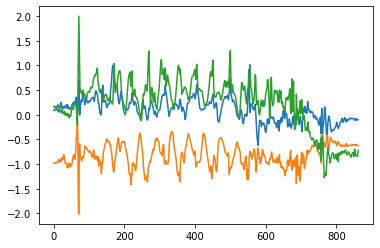

In [44]:
def plot_pedometer(data3D, ax=None):
    """ plot pedometer data
    """
    x = data3D[:, 0]
    y = data3D[:, 1]
    z = data3D[:, 2]

    if not ax:
        plt.figure()
        ax = plt
    ax.plot(x)
    ax.plot(y)
    ax.plot(z)

plot_pedometer(data)
plt.show()

从图中可以看出原始数据非常杂乱，需要分离出用户运动加速度和滤波。

### 5.2 Filter
首先是滤波器，我们需要三种参数的滤波器：
- `low_0_hz`：让0Hz附近频率的信号通过
- `low_5_hz`：让低于5Hz频率的信号通过
- `high_1_hz`：让高于1Hz频率的信号通过

回忆一下公式：
$$\text { output }_{i}=\alpha_{0}\left(\text {input}_{i} \beta_{0}+i n p u t_{i-1} \beta_{1}+i n p u t_{i-2} \beta_{2}-\text {output}_{i-1} \alpha_{1}-\text {output}_{i-2} \alpha_{2}\right)$$

In [20]:
class Filter:
    @staticmethod
    def low_0_hz(data):
        COEFFICIENTS_LOW_0_HZ = {
            'alpha': [1, -1.979133761292768, 0.979521463540373],
            'beta': [0.000086384997973502, 0.000172769995947004, 0.000086384997973502]
        }
        return Filter.filter(data, COEFFICIENTS_LOW_0_HZ)

    @staticmethod
    def low_5_hz(data):
        COEFFICIENTS_LOW_5_HZ = {
            'alpha': [1, -1.80898117793047, 0.827224480562408],
            'beta': [0.095465967120306, -0.172688631608676, 0.095465967120306]
        }
        return Filter.filter(data, COEFFICIENTS_LOW_5_HZ)

    @staticmethod
    def high_1_hz(data):
        COEFFICIENTS_HIGH_1_HZ = {
            'alpha': [1, -1.905384612118461, 0.910092542787947],
            'beta': [0.953986986993339, -1.907503180919730, 0.953986986993339]
        }
        return Filter.filter(data, COEFFICIENTS_HIGH_1_HZ)

    @staticmethod
    def filter(data, coef):
        fd = np.zeros_like(data)  # filtered_data

        for i in range(2, len(data)):
            fd[i] = coef['alpha'][0] * (data[i] * coef['beta'][0]
                                        + data[i-1] * coef['beta'][1]
                                        + data[i-2] * coef['beta'][2]
                                        - fd[i-1] * coef['alpha'][1]
                                        - fd[i-2] * coef['alpha'][2])
        return fd

有了滤波器，我们先分离出重力加速度。因为地球重力是常数，所以我们认为其变化率为0，只是随着姿态变化作用在3个方向上的分量不同。

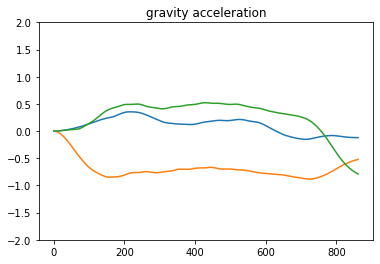

In [58]:
data_gravity = Filter.low_0_hz(data)

plot_pedometer(data_gravity)
plt.ylim([-2, 2])
plt.title('gravity acceleration')
plt.show()

有了重力加速度，我们用总的加速度减去重力加速度，就可以得到用户运动的加速度：

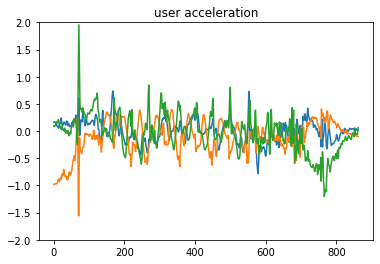

In [59]:
data_user = data - data_gravity
plot_pedometer(data_user)
plt.ylim([-2, 2])
plt.title('user acceleration')
plt.show()

对比一下原始的加速度信号和分离出的用户运动的加速度信号：

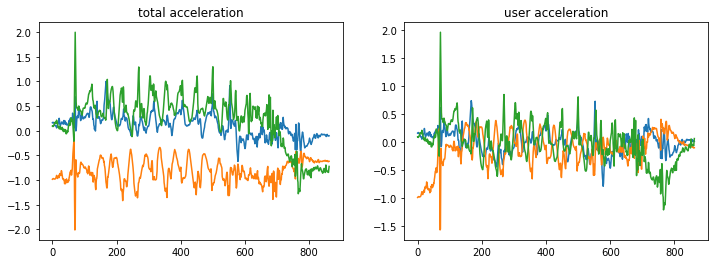

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_pedometer(data, axs[0])
plot_pedometer(data_user, axs[1])
axs[0].set_title('total acceleration')
axs[1].set_title('user acceleration')
plt.show()

### 5.3 Dot Product
因为`numpy.dot`不支持多组二维向量内积，我们先用对应元素相乘，再把每一行数据加起来就可以得到每一行的点乘结果：

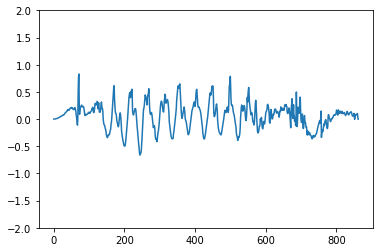

In [81]:
data_a = np.sum(data_user*data_gravity, axis=1)
plt.plot(data_a)
plt.ylim([-2, 2])
plt.show()

### 5.4 Noise reduction
最后我们过滤掉高频和低频噪音：

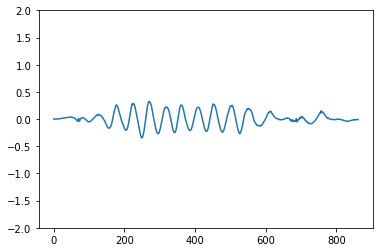

In [82]:
data_filtered = Filter.low_5_hz(data_a)
data_filtered = Filter.high_1_hz(data_filtered)
plt.plot(data_filtered)
plt.ylim([-2, 2])
plt.show()